# EEG preprocessing 

In this notebook: 
- Necessary imports
- Data loader for events, eeg and meta data
- Filtering algorithm
- EEG raw to epochs
- Epochs to evoked responses (ERPs)
- Averaging code for ERPS
- Grand average 
- Mismatch response
- saving filtered data

Preprocessing steps: 
+ Prepare EEG (1. Subtract reference (mastoids), 2. Detrend, 3. Filter, 4. Remove bad channels)
+ Segment EEG into standard and deviant epochs (ERPs) (1. subtract baseline, 2. Reject artefacts, 3. Average (for each marker/subject/channel separately))
+ Calculate Mismatch response (deviant - standard for a single subject) (check differences between channels and subjects)

## Imports

The data will be processed using the mne library. Also there are libraries made in eegyolk in order to load the metadata, eeg data and the event markers. Those libraries need to be imported

In [1]:
import mne      # toolbox for analyzing and visualizing EEG data
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
from ipywidgets import IntSlider, Output
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from math import nan

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
import initialization_functions #library to import data
import epod_helper

## Load metadata and eeg files

First the different pathways for the different datasets need to be defined. There are three pathways: eeg, metadata and events. The files can be loaded using the initialization_functions library. All event markers needs to be saved in a seperate folder. If not saved already, the event markers will be saved using the initialization_function library. The data must be saved in a separate folder called "epod_data_not_pushed" in the ePodium repository. 

In [2]:
data_path = "F:\Stage\ePODIUM\Data\ePodium (Projectfolder)"
path_eeg = os.path.join(data_path, "Dataset")
path_metadata = os.path.join(data_path, "Metadata")
path_eventmarkers = os.path.join(data_path, "events")

In [3]:
# load metadata
files_metadata = ["children.txt", "cdi.txt", "parents.txt", "CODES_overview.txt"]  
children, cdi, parents, codes = initialization_functions.load_metadata(path_metadata, files_metadata)

In [4]:
# load eeg
eeg, eeg_filename =  initialization_functions.load_dataset(path_eeg, preload=True) # preload must be set to True once on the cloud

Extracting EDF parameters from F:\Stage\ePODIUM\Data\ePodium (Projectfolder)\Dataset\103a.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3899391  =      0.000 ...  1904.000 secs...
5 EEG files loaded
5 EEG files loaded


In [5]:
# load events 
events_files = os.listdir(path_eventmarkers)
if len(events_files) == 0 or path_eventmarkers == False: # check if event markers are saved in a seperate folder
    initialization_functions.save_event_markers(path_eventmarkers, eeg, eeg_filename) # save event markers

event_markers = initialization_functions.load_events(path_eventmarkers, eeg_filename) # load event markers
event_markers_simplified = epod_helper.group_events_12(event_markers) # simplify events

5 Event Marker files loaded


## Data info

Choose which participant you want to view in the box below. 

In [6]:
index = widgets.IntText(
    step=0.1,
    description='Participant',
    disabled=False
)
widgets.VBox([index])

In [7]:
index = int(index.value)

Using matplotlib as 2D backend.
Opening raw-browser...


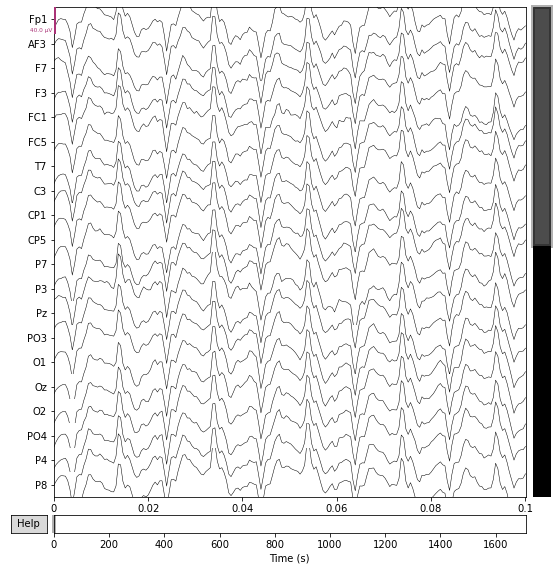

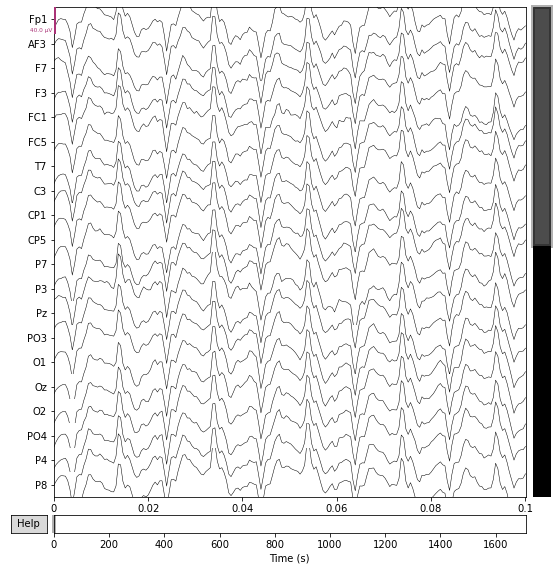

In [8]:
eeg[index].plot(duration=0.1)

<ipython-input-9-39cc3f276206>:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(event_markers_simplified[index], event_id = epod_helper.event_dictionary)


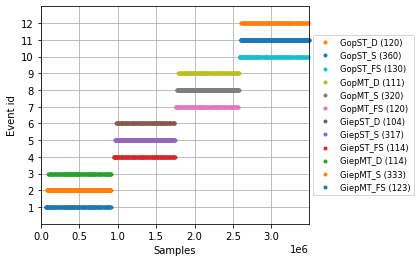

In [9]:
%matplotlib inline 
fig = mne.viz.plot_events(event_markers_simplified[index], event_id = epod_helper.event_dictionary)

## Filtering raw EEG 

Below you can define the frequencies for the bandpass filter. The lowpass can not be below 0 and the highpass can not be higher then 100. Most common bandpass filter is filtering between 0.1 and 30. 

In [10]:
lowpass = widgets.BoundedFloatText(
    value=0.1,
    min=0,
    max=100,
    step=0.1,
    description='lowpass:',
    disabled=False
)

highpass = widgets.BoundedFloatText(
    value=30,
    min=0,
    max=100,
    step=0.1,
    description='highpass:',
    disabled=False
)

widgets.VBox([lowpass,highpass])


In [11]:
# change type to integer
lowpass = float(lowpass.value)
highpass = float(highpass.value)

The number of freqs can vary and be adjusted by changing `n`. Example for frequency can be `[60, 120, 180, 240]`.

In [12]:
n = 4
seed = np.zeros(n)
freq = list(widgets.BoundedIntText(
              description = 'freq[{}]'.format(i),
              min = 0, 
              max = 300, 
              step = 1, 
              value = seed[i]) 
          for i in range(n))

widgets.VBox(children = freq)

In [13]:
freqs = []
for i in range(len(freq)): freqs.append(freq[i].value)

This filter contains a bandpass filter, with as input the parameters `lowpass` and `highpass`. It also contains a notch filter to filter out power line noise and needs as input `freqs` for frequencies to apply the notch filter on. The next input is `mastoid_channels`, to subtract the reference from the raw eeg data. Finally, channels from the eeg can be dropped by adjusting the `drop_ch`. 

In [14]:
mastoid_channels = ['EXG1', 'EXG2']
drop_ch = ['EXG1', 'EXG2','EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']

for i in range(len(eeg)): eeg[i] = hf.filter_eeg_raw(eeg[i], lowpass, highpass, freqs, mastoid_channels, drop_ch)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 67585 samples (33.000 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 sec)

EEG channel type selected for re-referencing
Applying a 

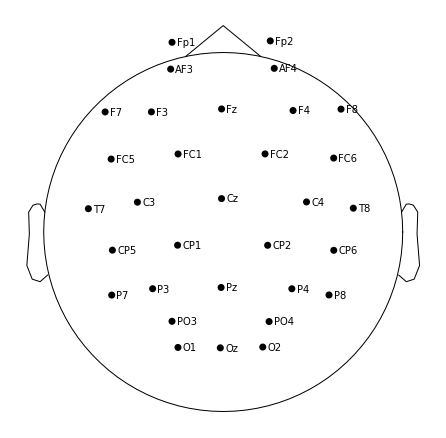

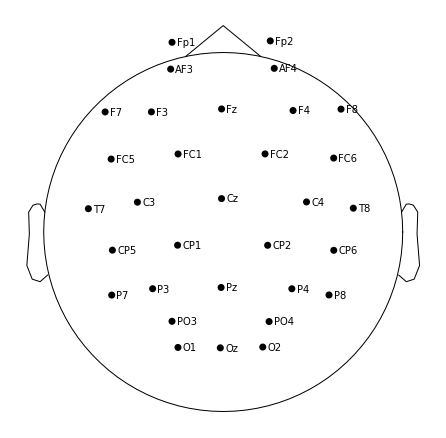

In [15]:
eeg[index].plot_sensors(ch_type='eeg', show_names=True)

In [16]:
eeg[index].info['ch_names']

['Fp1',
 'AF3',
 'F7',
 'F3',
 'FC1',
 'FC5',
 'T7',
 'C3',
 'CP1',
 'CP5',
 'P7',
 'P3',
 'Pz',
 'PO3',
 'O1',
 'Oz',
 'O2',
 'PO4',
 'P4',
 'P8',
 'CP6',
 'CP2',
 'C4',
 'T8',
 'FC6',
 'FC2',
 'F4',
 'F8',
 'AF4',
 'Fp2',
 'Fz',
 'Cz']

## Creating epoched data

Epochs are created with joining the eeg data with a specific event.  mne.Epochs automaticaly create a baseline correction and artefact rejection. 

In [17]:
event_dictionary = epod_helper.event_dictionary
event_dictionary

{'GiepMT_FS': 1,
 'GiepMT_S': 2,
 'GiepMT_D': 3,
 'GiepST_FS': 4,
 'GiepST_S': 5,
 'GiepST_D': 6,
 'GopMT_FS': 7,
 'GopMT_S': 8,
 'GopMT_D': 9,
 'GopST_FS': 10,
 'GopST_S': 11,
 'GopST_D': 12}

In order to create the epochs, the time before `tmin` and after an event `tmax` needs to be defined. The default values are set to -0.3 and 0.7. `tmin` and `tmax` are the start and stop time relative to each event.

In [18]:
tmin = widgets.BoundedFloatText(
    value=-0.3,
    min=-1,
    max=1,
    step=0.1,
    description='tmin:',
    disabled=False
)

tmax = widgets.BoundedFloatText(
    value=0.7,
    min=-1,
    max=1,
    step=0.1,
    description='tmax:',
    disabled=False
)

widgets.VBox([tmin,tmax])

In [19]:
tmin = float(tmin.value)
tmax = float(tmax.value)

In [20]:
eeg[1]

<RawEDF | 101b.bdf, 32 x 3907584 (1908.0 s), ~954.0 MB, data loaded>

For a selected event, an interval is created with a time before and after event. This represents an epoch. The function automatically performs a baseline correction. 

In [22]:
epochs = hf.create_epochs(eeg, event_markers_simplified, tmin, tmax)

Not setting metadata
2266 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2389 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
2208 matching events found
Setting baseline interval to [-0.2998046875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [23]:
epochs

[<Epochs |  2266 events (good & bad), -0.299805 - 0.700195 sec, baseline -0.299805 – 0 sec, ~48 kB, data not loaded,
  '1': 123
  '2': 333
  '3': 114
  '4': 114
  '5': 317
  '6': 104
  '7': 120
  '8': 320
  '9': 111
  '10': 130
  and 2 more events ...>,
 <Epochs |  2440 events (good & bad), -0.299805 - 0.700195 sec, baseline -0.299805 – 0 sec, ~48 kB, data not loaded,
  '1': 130
  '2': 360
  '3': 120
  '4': 130
  '5': 360
  '6': 120
  '7': 130
  '8': 360
  '9': 120
  '10': 130
  and 2 more events ...>,
 <Epochs |  2389 events (good & bad), -0.299805 - 0.700195 sec, baseline -0.299805 – 0 sec, ~48 kB, data not loaded,
  '1': 130
  '2': 360
  '3': 120
  '4': 119
  '5': 331
  '6': 109
  '7': 130
  '8': 360
  '9': 120
  '10': 130
  and 2 more events ...>,
 <Epochs |  2440 events (good & bad), -0.299805 - 0.700195 sec, baseline -0.299805 – 0 sec, ~48 kB, data not loaded,
  '1': 130
  '2': 360
  '3': 120
  '4': 130
  '5': 360
  '6': 120
  '7': 130
  '8': 360
  '9': 120
  '10': 130
  and 2 mo

## Create ERPS

Evoked responses are created by averaging the epochs for a specific event. The function therefore needs as input the created `epochs` and `event_dictionary` containing the different types of events used in the experiment. 

In [24]:
evoked = hf.evoked_responses(epochs, event_dictionary)

## ERP visualizations for a single subject

Below each event is plotted for a single subject with the average for each channel. 

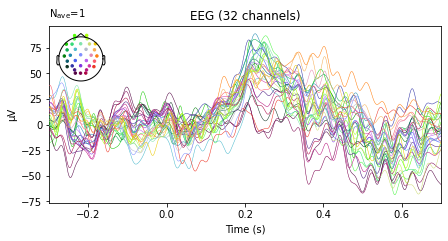

('GiepMT_FS', 1)


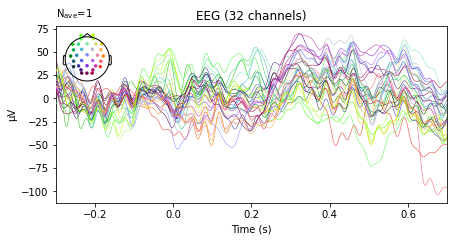

('GiepMT_S', 2)


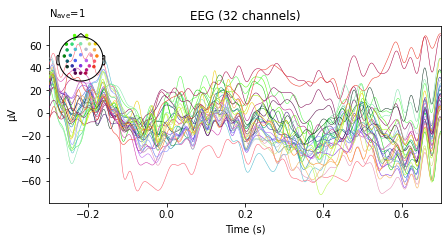

('GiepMT_D', 3)


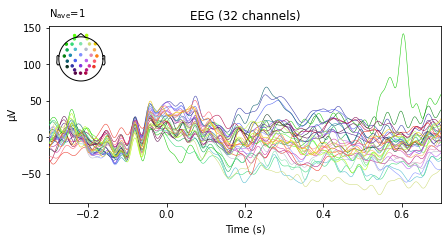

('GiepST_FS', 4)


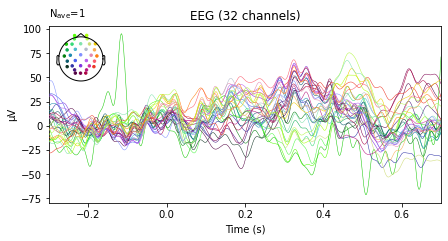

('GiepST_S', 5)


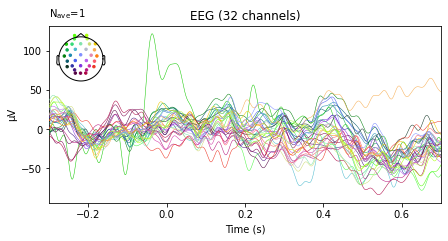

('GiepST_D', 6)


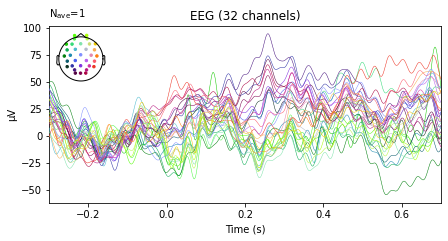

('GopMT_FS', 7)


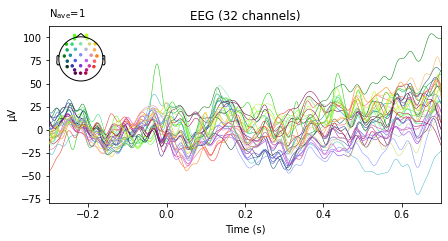

('GopMT_S', 8)


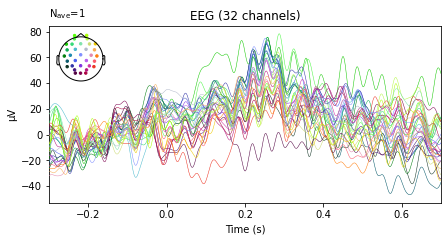

('GopMT_D', 9)


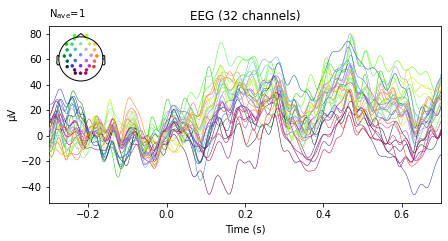

('GopST_FS', 10)


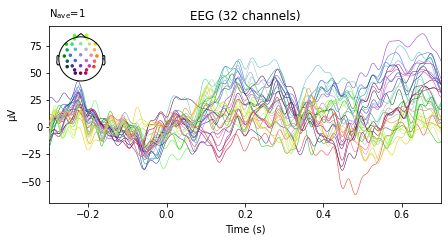

('GopST_S', 11)


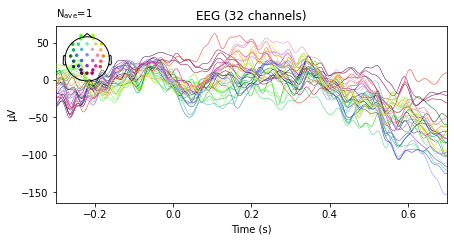

('GopST_D', 12)


In [25]:
for i in range(len(event_dictionary)):
    evoked[index][i].plot(spatial_colors=True, exclude='bads')
    print(([key for key in epod_helper.event_dictionary.keys()][i], [value for value in epod_helper.event_dictionary.values()][i]))

The grand average is calculated by the average response on all events combined for each channel. 

Identifying common channels ...


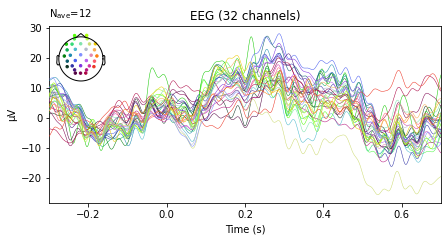

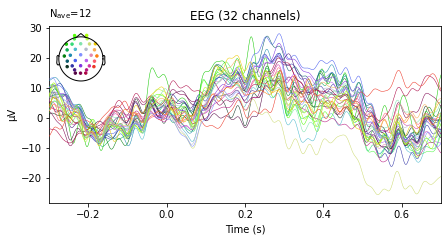

In [26]:
ga_singlesub = mne.grand_average(evoked[index])
ga_singlesub.plot(spatial_colors=True)

We will now only look at the standard events, which are events 2, 5, 8 and 11. The first standards were removed, since the participant need some time to adjust to the standard not being 'new' anymore. The deviant events differ from the standard one and are 3, 6, 9 and 12. First, the average per channel for the standard and deviant is calculated and plotted. The second plots shows the mean over all channels between the standard and deviant. 

In [27]:
std_evoked = epochs[index][2,5,8,11].average()
dev_evoked = epochs[index][3,6,9,12].average()

In [28]:
std_evoked

<Evoked | '0.75 × 1 + 0.25 × 2' (average, N=4), -0.2998 – 0.7002 sec, baseline -0.299805 – 0 sec, 32 ch, ~561 kB>

In [29]:
evoked_diff = mne.combine_evoked([std_evoked, dev_evoked], weights=[1, -1])

Need more than one channel to make topography for eeg. Disabling interactivity.


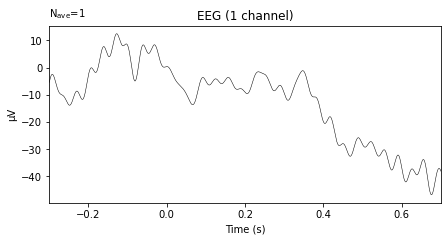

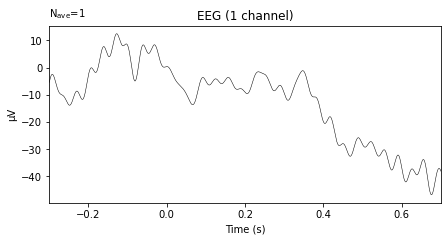

In [30]:
chnames = evoked_diff.info['ch_names']

chnames = mne.pick_channels(evoked_diff.info['ch_names'], include=chnames)

roi_dict = dict(left_ROI=chnames)
roi_evoked = mne.channels.combine_channels(evoked_diff, roi_dict, method='mean')
roi_evoked.plot()


Deviant
Need more than one channel to make topography for eeg. Disabling interactivity.


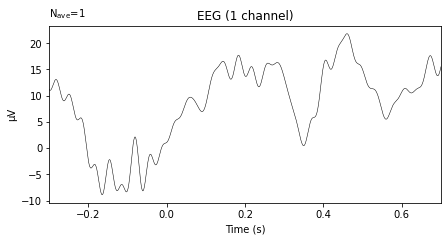

Standard
Need more than one channel to make topography for eeg. Disabling interactivity.


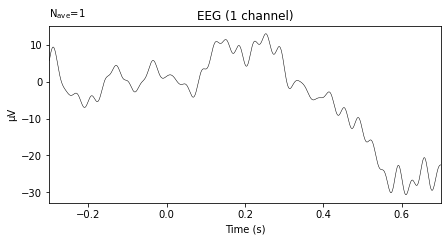

mismatch response
Need more than one channel to make topography for eeg. Disabling interactivity.


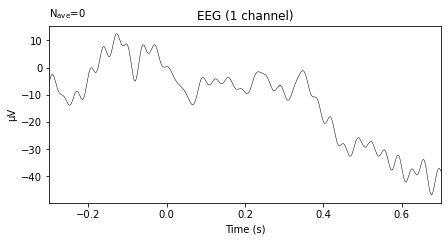

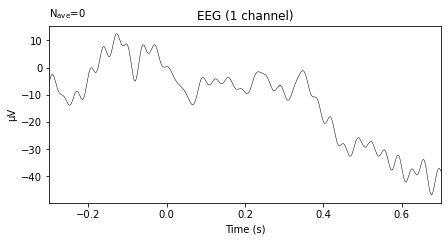

In [31]:
chnames = evoked_diff.info['ch_names']
chnames_dev = dev_evoked.info['ch_names']

chnames_std = mne.pick_channels(std_evoked.info['ch_names'], include=chnames)
chnames_dev = mne.pick_channels(dev_evoked.info['ch_names'], include=chnames_dev)

roi_dict = dict(left_ROI=chnames_std)
roi_evoked_dev = mne.channels.combine_channels(dev_evoked, roi_dict, method='mean')
print("Deviant") 
roi_evoked_dev.plot()
roi_evoked_std = mne.channels.combine_channels(std_evoked, roi_dict, method='mean')
print("Standard")
roi_evoked_std.plot()
evoked_diff = mne.combine_evoked([roi_evoked_std, roi_evoked_dev], weights=[1, -1])
print("mismatch response")
evoked_diff.plot()

combining channels using "mean"
combining channels using "mean"


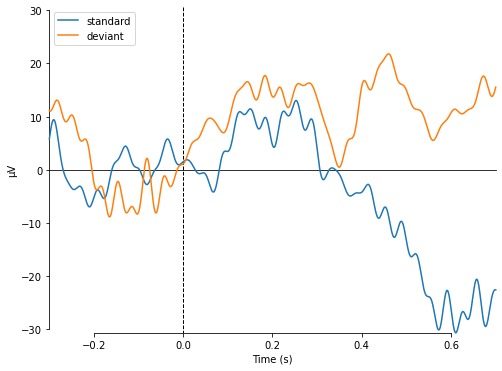

[<Figure size 576x432 with 1 Axes>]

In [32]:
evokeds = dict(standard=std_evoked, deviant=dev_evoked)
mne.viz.plot_compare_evokeds(evokeds, combine='mean')

## Save evoked data in new folder

In [33]:
epoch_folder = 'F:\Stage\ePODIUM\ePodium\dyslexiaprediction_nadine\epochs'
for i in range(len(epochs)):
    epoch_file = os.path.join(epoch_folder, eeg_filename[i]+"_epo.fif")
    epochs[i].save(epoch_file, overwrite=True)
    print("\n", i+1, " out of ", len(epochs), " saved.")

Overwriting existing file.
Using data from preloaded Raw for 2266 events and 2049 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 2049 original time points ...
Using data from preloaded Raw for 2266 events and 2049 original time points ...

 1  out of  5  saved.
Overwriting existing file.
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 2049 original time points ...
Using data from preloaded Raw for 2440 events and 2049 original time points ...

 2  out of  5  saved.
Overwriting existing file.
Using data from preloaded Raw for 2389 events and 2049 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 2049 original time points ...
Using data from preloaded Raw for 2389 events and 2049 original time points ...

 3  out of  5  saved.
Overwriting existing file.
Using data from preloaded Raw for 2440 events and

## Create DataFrame with metadata and eeg/epoch paths

In [34]:
parents.rename(columns = {'child':'ParticipantID'}, inplace=True)
cdi.rename(columns = {'participant':'ParticipantID'}, inplace=True)

In [35]:
metadata = pd.merge(cdi, children, on="ParticipantID")
metadata = pd.merge(metadata, parents, on="ParticipantID")

In [36]:
metadata = metadata.drop(['b01 - Geluidseffecten en dierengeluiden',
       'b02 - Dierennamen', 'b03 - Voertuigen', 'b04 - Speelgoed',
       'b05 - Eten en drinken', 'b06 - Kleding', 'b07 - Delen van het lichaam',
       'b08 - Kleine huishoudelijke voorwerpen', 'b09 - Meubels en kamers',
       'b10 - Voorwerpen buitenshuis', 'b11 - Plaatsen buitenshuis',
       'b12 - Mensen', 'b13 - Spelletjes en routines',
       'b14 - Omschrijvende woorden', 'b15 - Werkwoorden',
       'b16 - Woorden over tijd', 'b17 - Voornaamwoorden',
       'b18 - Vragende woordjes', 'b19 - Voorzetsels en plaatsbepalingen',
       'b20 - Hoeveelheden en lidwoorden', 'b21 - Hulpwerkwoorden',
       'b22 - Voegwoorden', 'p01 - Geluidseffecten en dierengeluiden',
       'p02 - Dierennamen', 'p03 - Voertuigen', 'p04 - Speelgoed',
       'p05 - Eten en drinken', 'p06 - Kleding', 'p07 - Delen van het lichaam',
       'p08 - Kleine huishoudelijke voorwerpen', 'p09 - Meubels en kamers',
       'p10 - Voorwerpen buitenshuis', 'p11 - Plaatsen buitenshuis',
       'p12 - Mensen', 'p13 - Spelletjes en routines',
       'p14 - Omschrijvende woorden', 'p15 - Werkwoorden',
       'p16 - Woorden over tijd', 'p17 - Voornaamwoorden',
       'p18 - Vragende woordjes', 'p19 - Voorzetsels en plaatsbepalingen',
       'p20 - Hoeveelheden en lidwoorden', 'p21 - Hulpwerkwoorden',
       'p22 - Voegwoorden', 'wB - Woorduiteinden', 'wC - Woordvormen',
       'zE - Zinnen',  'Woordvormen - Ruwe score', 'Woordvormen - Percentiel',
       'Woordvormen - Taalleeftijd', 'Zinnen - Ruwe score',
       'Zinnen - Percentiel', 'Zinnen - Taalleeftijd', 'VocabularyComprehension_Raw',
       'VocabularyComprehension_Percentile',
       'VocabularyComprehension_LanguageAge', 'VocabularyProduction_Raw',
       'VocabularyProduction_Percentile', 'VocabularyProduction_LanguageAge', 'Sex', 'Age_original_a', 'Age_days_a', 'Age_months_a',
       'Age_original_b', 'Age_days_b', 'Age_months_b', 'emt_mother','klepel_mother', 'vc_mother', 'dyslexia_mother_accToMother',
       'emt_father', 'klepel_father', 'vc_father',
       'dyslexia_father_accToFather'], axis = 1)

In [37]:
metadata['eeg_file']= metadata['ParticipantID'].astype(str) + metadata['test']

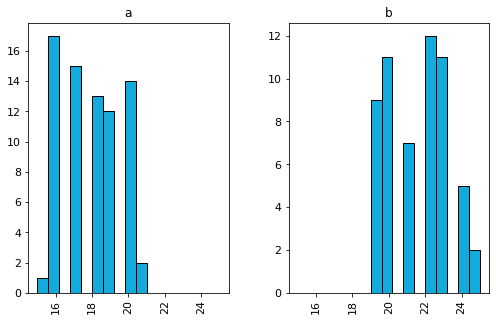

In [38]:
hist = metadata.hist(column='age_months',by='test',color='#12ABDB',sharex=True, figsize=(8,5), xlabelsize=11, ylabelsize=11,bins=10,ec='black') 

In [39]:
epoch_filename = []

# Iterate directory
for path in os.listdir(epoch_folder):
    # check if current path is a file
    if os.path.isfile(os.path.join(epoch_folder, path)):
        epoch_filename.append(path)
print(epoch_filename)

['101a_epo.fif', '101b_epo.fif', '102a_epo.fif', '102b_epo.fif', '103a_epo.fif']


In [40]:
metadata['eeg_path'] = path_eeg
metadata['path_epoch'] = epoch_folder

In [41]:
df_eegfilenames = pd.DataFrame(eeg_filename, columns=['eeg_file'])
df_epochfilenames = pd.DataFrame(epoch_filename, columns=['epoch_file'])

In [42]:
df_epochfilenames['eeg_file'] = df_epochfilenames.epoch_file.str[:4]

In [43]:
df = pd.merge(df_eegfilenames, metadata, on='eeg_file')
df = pd.merge(df, df_epochfilenames, on='eeg_file')

In [44]:
df.to_csv('metadata.csv', index=False)